In [1]:
%pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\python.exe -m pip install --upgrade pip' command.


In [2]:
from src.utils import astype_to_category, convert_category_into_integer
from src.model.decision_tree import decision_tree
from src.model.logistic_regression import logit
from src.model.svm import svc

import pandas as pd
import numpy as np
import random
from tqdm import tqdm

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as ds
import torchvision.transforms as transforms

import lightning as L
from lightning.pytorch.trainer import Trainer
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report


import warnings

,CustomerCareCalls,MonthsInService,DroppedCalls,OverageMinutes
0,0.0,61,0.7,0.0
1,0.0,58,0.3,0.0
2,0.0,60,0.0,0.0
3,4.3,59,52.0,0.0
4,0.0,53,0.0,0.0
...,...,...,...,...
51035,0.7,30,5.7,0.0
51037,0.0,30,0.7,43.0
51040,0.0,30,14.3,4.0
51041,0.0,30,4.0,250.0


0        1
1        1
2        0
3        0
4        1
        ..
51035    0
51037    0
51040    0
51041    1
51043    0
Name: Churn, Length: 49752, dtype: int32

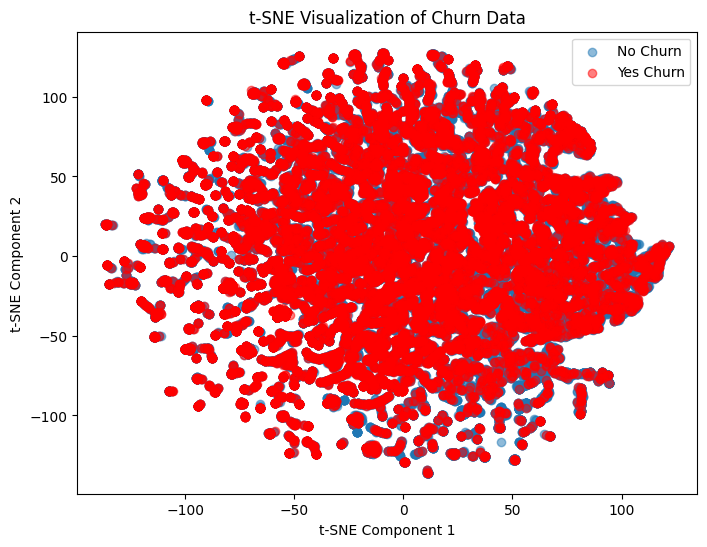

              precision    recall  f1-score   support

           0       0.72      0.81      0.76     14157
           1       0.32      0.22      0.26      5744

    accuracy                           0.64     19901
   macro avg       0.52      0.52      0.51     19901
weighted avg       0.60      0.64      0.62     19901



In [3]:
## 경고 무시
warnings.filterwarnings('ignore')
## train, test 데이터 불러오기
seed = 0
origin_train = pd.read_csv('../data/train.csv', encoding='cp949').dropna()
origin_test = pd.read_csv('../data/test.csv', encoding='cp949')
# train, valid = train_test_split(origin_train, test_size=0.4, random_state=seed)
# 데이터 로드 (파일에서 읽어올 경우)
# df = pd.read_csv('your_data.csv')

# 타겟 변수와 입력 변수 분리
origin_train['Churn'] = np.where(origin_train['Churn'] == 'Yes', 1, 0)
columns = ['CustomerCareCalls', 'MonthsInService', 'DroppedCalls', 'OverageMinutes']
X_train = origin_train.filter(items=columns)
y_train = origin_train['Churn']
objects = []
for idx in range(len(X_train.columns)):
    if X_train.dtypes[idx] == object:
        objects.append(X_train.columns[idx])
X_train, _ = convert_category_into_integer(X_train, objects)
# train = astype_to_category(train)

# # 범주형 변수 One-hot 인코딩 (범주형 변수만 선택)
# X_train = pd.get_dummies(X_train, drop_first=True)
# display(X_train)
# display(y_train)
# 데이터 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# t-SNE 적용 (2차원으로 축소)
tsne = TSNE(n_components=2, random_state=seed)
X_train = tsne.fit_transform(X_train)

# t-SNE 결과 시각화 (이탈 여부에 따른 시각화)
plt.figure(figsize=(8, 6))
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], label='No Churn', alpha=0.5)
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], label='Yes Churn', alpha=0.5, color='red')
plt.title('t-SNE Visualization of Churn Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.4, random_state=seed)

# Random Forest 분류기 모델 훈련
rf_model = RandomForestClassifier(random_state=seed)
rf_model.fit(X_train, y_train)

# 예측 및 평가
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

In [8]:
origin_train = pd.read_csv('../data/train.csv', encoding='cp949').dropna()
origin_test = pd.read_csv('../data/test.csv', encoding='cp949')

# origin_train = origin_train.query("MonthlyRevenue < 100")
# origin_train = origin_train.query("MonthlyMinutes < 1200")
# # origin_train = origin_train.query("TotalRecurringCharge < 80")
# # origin_train = origin_train.query("DirectorAssistedCalls < 5")
# origin_train = origin_train.query("OverageMinutes < 20")
columns = ['Churn', 'CustomerCareCalls', 'MonthsInService', 'DroppedCalls', 'OverageMinutes']
train =  origin_train.filter(items=columns)
test = origin_test.filter(items=columns)

# ## 범주형 변수 인코딩하기
train.loc[:, 'Churn'] = LabelEncoder().fit_transform(train.Churn)

## 데이터 종류가 object인 칼럼을 카테고리화 하기
# train = astype_to_category(train)
# test = astype_to_category(test)

## 타겟 변수 정의
target = 'Churn'

## train 데이터 분할하기
seed = 0
train, valid = train_test_split(train, test_size=0.4, random_state=seed)
# print(len(train), len(valid), len(test))
## 특성 스케일링
# compare_columns = train.columns.difference(objects)
# standard_scaler = StandardScaler()
# train.loc[:, compare_columns] = standard_scaler.fit_transform(train.loc[:, compare_columns])
# valid.loc[:, compare_columns] = standard_scaler.transform(valid.loc[:, compare_columns])
# test.loc[:, compare_columns] = standard_scaler.transform(test.loc[:, compare_columns])

scaler = StandardScaler()
scaled_train = scaler.fit_transform(train)
scaled_train = pd.DataFrame(scaled_train, columns=train.columns)

# PCA 적용 (주성분 개수는 임의로 2개로 설정)
tsne = PCA(n_components=2, random_state=seed)
pca_train = tsne.fit_transform(train.drop(columns=target))
pca_train = pd.DataFrame(data=pca_train, columns=['PC1', 'PC2'])
pca_train[target] = train[target]

pca_train = pca_train.loc[pca_train.Churn.isna() == False]
# display(pd.DataFrame(pca_train))

# 각 주성분이 설명하는 분산 비율 확인
print(f"Explained Variance Ratio: {tsne.explained_variance_ratio_}")

plt.figure(figsize=(12,8))
plt.scatter(pca_train['PC1'], pca_train['PC2'], c=pca_train[target], cmap='viridis', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Telecom Churn Data')
plt.colorbar(label=target)
plt.show()

# 클러스터 수 설정 (임의로 2개 클러스터)
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=seed)

# 클러스터링 적용
kmeans.fit(pca_train)
labels = kmeans.labels_

# 클러스터링 결과를 PCA 결과에 추가
pca_train['Cluster'] = labels

# 클러스터링 결과 시각화
plt.figure(figsize=(8, 6))
plt.scatter(pca_train['PC1'], pca_train['PC2'], c=pca_train['Cluster'], cmap='rainbow', alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clustering on PCA Components')
plt.colorbar(label='Cluster')
plt.show()

# train = pd.DataFrame(train, columns=origin_train.columns)
# df_train.corr()
# 범주형 데이터 제외 시킨 칼럼들
# compare_columns = train.columns.difference(objects)

# logit(target, train, valid, seed, compare_columns)
# decision_tree(target, train, test, seed)
# svc(target, train, valid, seed, sample_size=300)

KeyError: 'C'

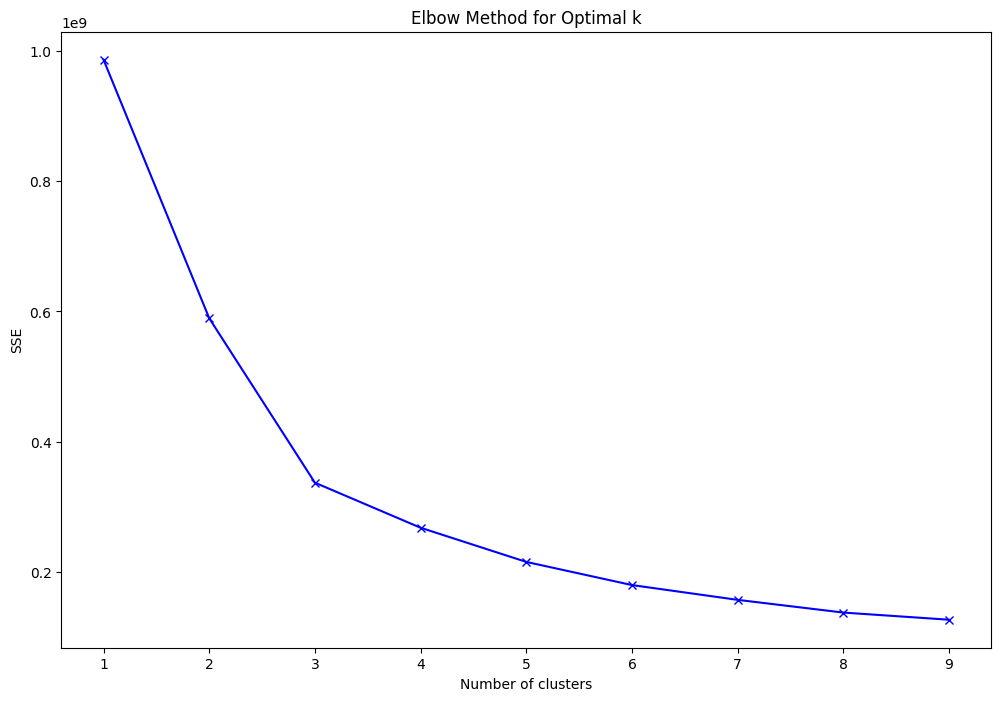

In [30]:
sse = []
k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=seed)
    kmeans.fit(pca_train)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(12, 8))
plt.plot(k_range, sse, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal k')
plt.show()

                PC1        PC2     Churn
Cluster                                 
0       -158.316650 -33.437062  0.300165
1        347.847082  81.271694  0.291391


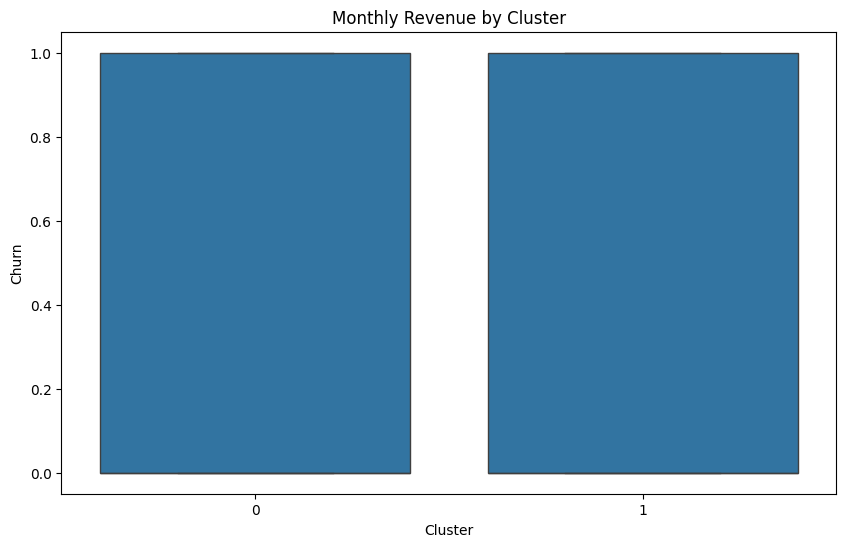

Churn         0.0       1.0
Cluster                    
0        0.699835  0.300165
1        0.708609  0.291391


In [36]:
# Cluster 정보를 원래 데이터에 추가
pca_train['Cluster'] = kmeans.labels_

# 각 클러스터별로 주요 특성들의 통계 정보 확인
cluster_stats = pca_train.groupby('Cluster').mean()
print(cluster_stats)

# 월 수입에 대한 클러스터별 박스 플롯
plt.figure(figsize=(10,6))
sns.boxplot(data=pca_train, x='Cluster', y='Churn')
plt.title('Monthly Revenue by Cluster')
plt.show()

churn_counts = pca_train.groupby('Cluster')['Churn'].value_counts(normalize=True).unstack()
print(churn_counts)